<a href="https://colab.research.google.com/github/adildauletkhan/archi/blob/master/bab_fluid_logs_10wells_lithology_clay_smooth__282_29.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
!pip install lasio matplotlib scipy


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import lasio
import os
import glob
import zipfile
from scipy.ndimage import gaussian_filter1d


In [86]:
import json
import random

with open("/mnt/data/wellLogs.mocks.json", "r") as f:
    data = json.load(f)

wells = []
for feature in data["features"]:
    for reservoir in feature["properties"]["reservoirs"]:
        for well in reservoir["wells"]:
            wells.append({
                "wellName": well["wellName"],
                "lngLat": well["lngLat"]
            })

manual_wells = {"BB01601", "BB01831", "BB02271","BB02301", "BB05531", "BB07911", "BB10421" }
manual_entries = [w for w in wells if w["wellName"] in manual_wells]
remaining_entries = [w for w in wells if w["wellName"] not in manual_wells]
random_entries = random.sample(remaining_entries, 0)

final_wells = manual_entries + random_entries

well_coordinates = [
    {
        "name": w["wellName"],
        "lon": w["lngLat"][0],
        "lat": w["lngLat"][1]
    }
    for w in final_wells
]


In [119]:
folder = "BAB_litho_clay_smooth_logs_3"
os.makedirs(folder, exist_ok=True)

for i, well in enumerate(well_coordinates):  # updated with custom well names
    depth = np.linspace(1000, 2000, 500)

    # задаем случайную глубину начала и конца газа
    gas_start = np.random.randint(1200, 1600)
    gas_end = gas_start + np.random.randint(100, 300)
    gas_zone = (depth >= gas_start) & (depth <= gas_end)

    gas_profile = np.zeros_like(depth)
    gas_profile[gas_zone] = np.random.uniform(0.025, 0.1, gas_zone.sum())
    gas_frac = gaussian_filter1d(gas_profile, sigma=10)

    max_water = 0.20 - gas_frac
    water_frac = np.clip(np.random.uniform(0.05, 0.15, len(depth)), 0, max_water)

    fluid_total = gas_frac + water_frac
    rock_total = 1 - fluid_total

    dolomite_ratio = np.random.uniform(0.2, 0.25, len(depth))
    calcite_ratio = np.random.uniform(0.3, 0.75, len(depth))
    #clay_ratio = 1 - dolomite_ratio - calcite_ratio
    #clay_ratio = np.clip(clay_ratio, 0.05, 0.4)

    mineral_total = dolomite_ratio + calcite_ratio
    dolomite = dolomite_ratio / mineral_total * rock_total
    calcite = calcite_ratio / mineral_total * rock_total
    #clay = clay_ratio / mineral_total * rock_total


    dt_base = 250 + i * 0.7  # Базовое значение DT для каждой скважины
    dt = dt_base - 10 * calcite + 2 * dolomite + 50 * gas_frac
    dt += np.random.normal(0, 4, len(depth))

    #dt = 270 - 10 * dolomite + 2 * calcite + 8 * clay + 50 * gas_frac
    #dt += np.random.normal(0, 3, len(depth))

    las = lasio.LASFile()
    las.append_curve("DEPT", depth, unit="m", descr="Depth")
    las.append_curve("DT", dt, unit="us/ft", descr="Delta-T")
    las.append_curve("CALCITE", calcite * 100, unit="%", descr="Calcite content")
    las.append_curve("DOLOMITE", dolomite * 100, unit="%", descr="Dolomite content")
    #las.append_curve("CLAY", clay * 100, unit="%", descr="Clay content")
    las.append_curve("GAS", gas_frac * 100, unit="%", descr="Gas saturation")
    las.append_curve("WATER", water_frac * 100, unit="%", descr="Water saturation")
    las.well.WELL.value = well["name"]
    las.well.LOC.value = f"Lat={well['lat']}, Lon={well['lon']}"
    las.write(f"{folder}/{well['name']}.las")

print("✅ LAS files generated with CLAY and smoothed gas transitions.")


✅ LAS files generated with CLAY and smoothed gas transitions.


In [120]:
import pandas as pd
import lasio
import glob

las_files = sorted(glob.glob("BAB_litho_clay_smooth_logs_3/*.las"))
well_data = []

for file in las_files:
    las = lasio.read(file)
    well_name = las.well.WELL.value
    avg_dt = las["DT"].mean()  # Вычисляем среднее DT
    well_data.append([well_name, avg_dt])

df = pd.DataFrame(well_data, columns=["Well Name", "Average DT"])
display(df)  # Выводим таблицу

,Well Name,Average DT
0,BB01601,246.294303
1,BB01831,245.424012
2,BB02271,246.832199
3,BB02301,249.273775
4,BB05531,248.194759
5,BB07911,245.153873
6,BB10421,247.699966


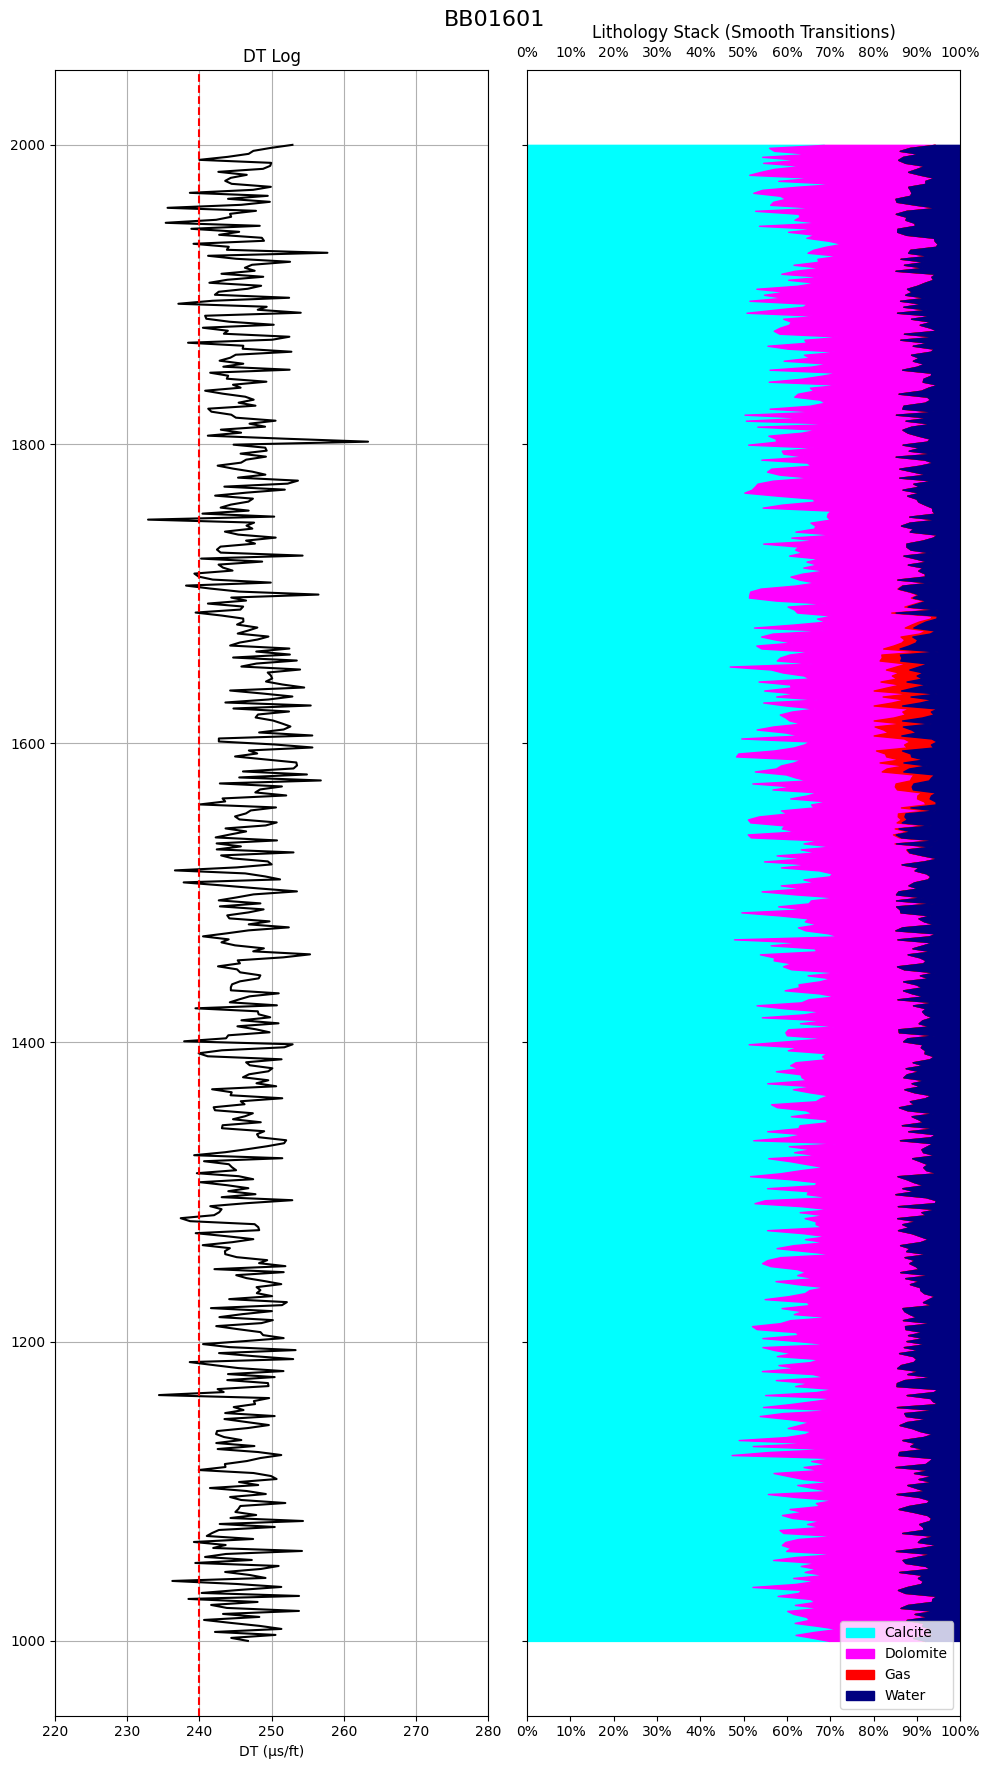

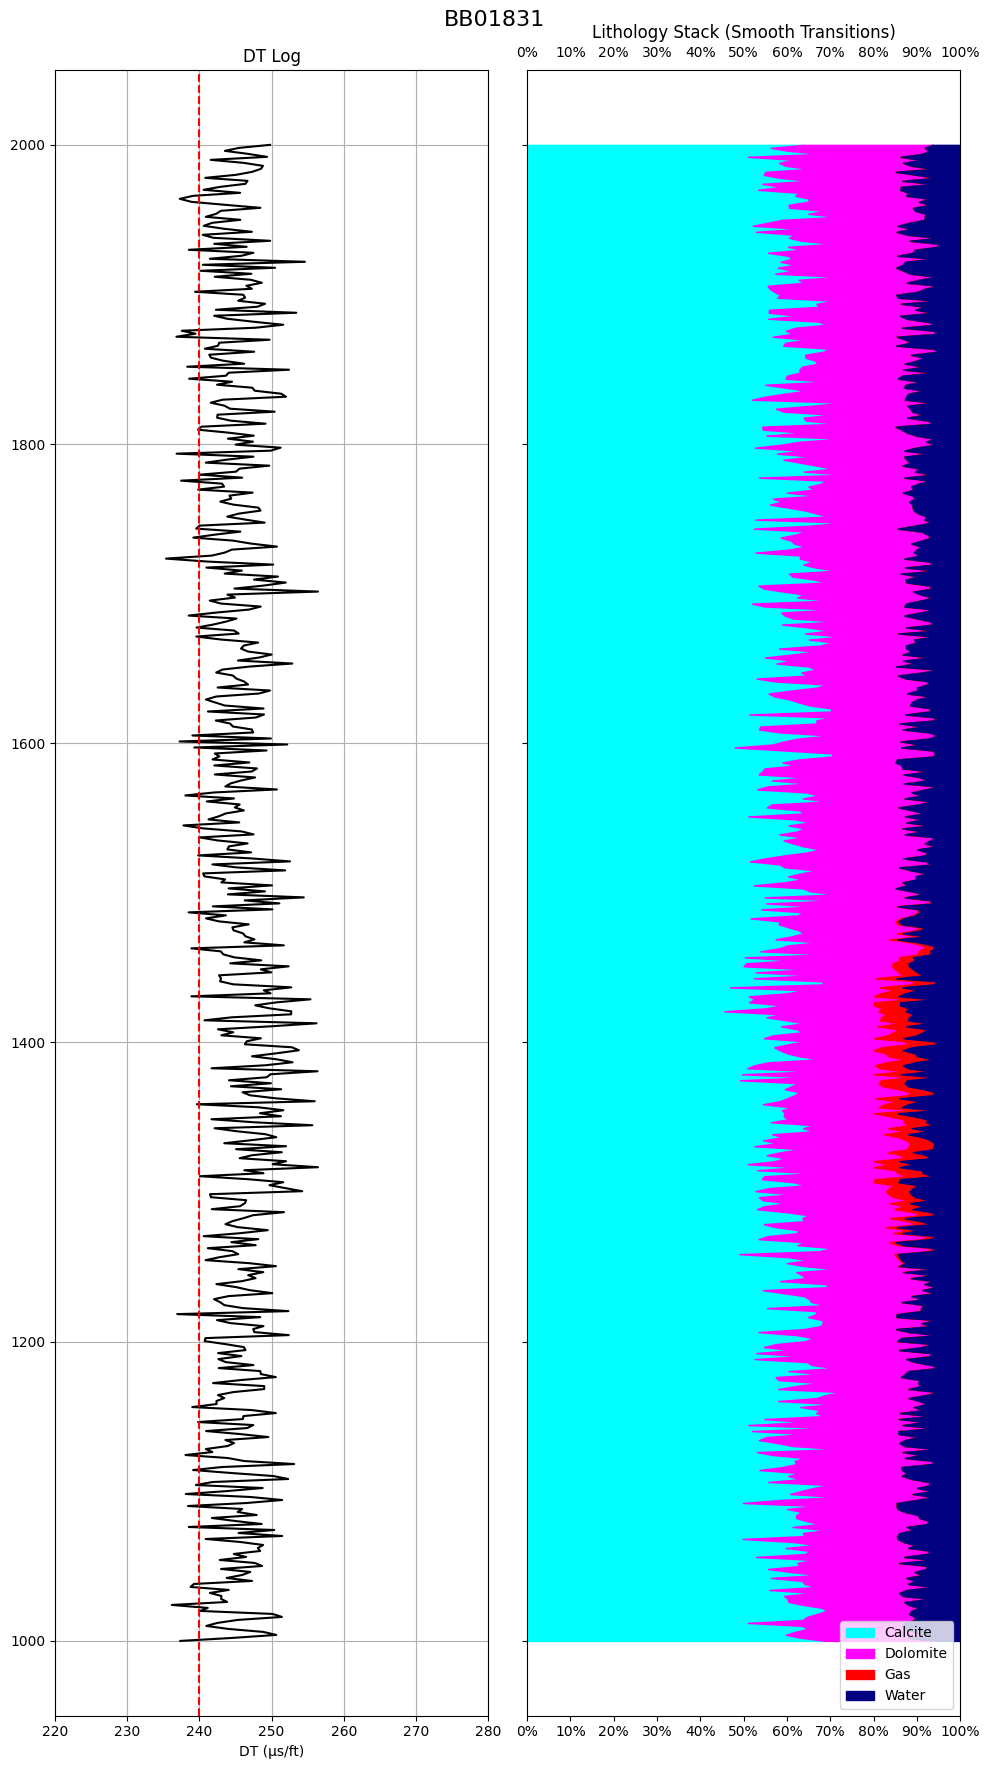

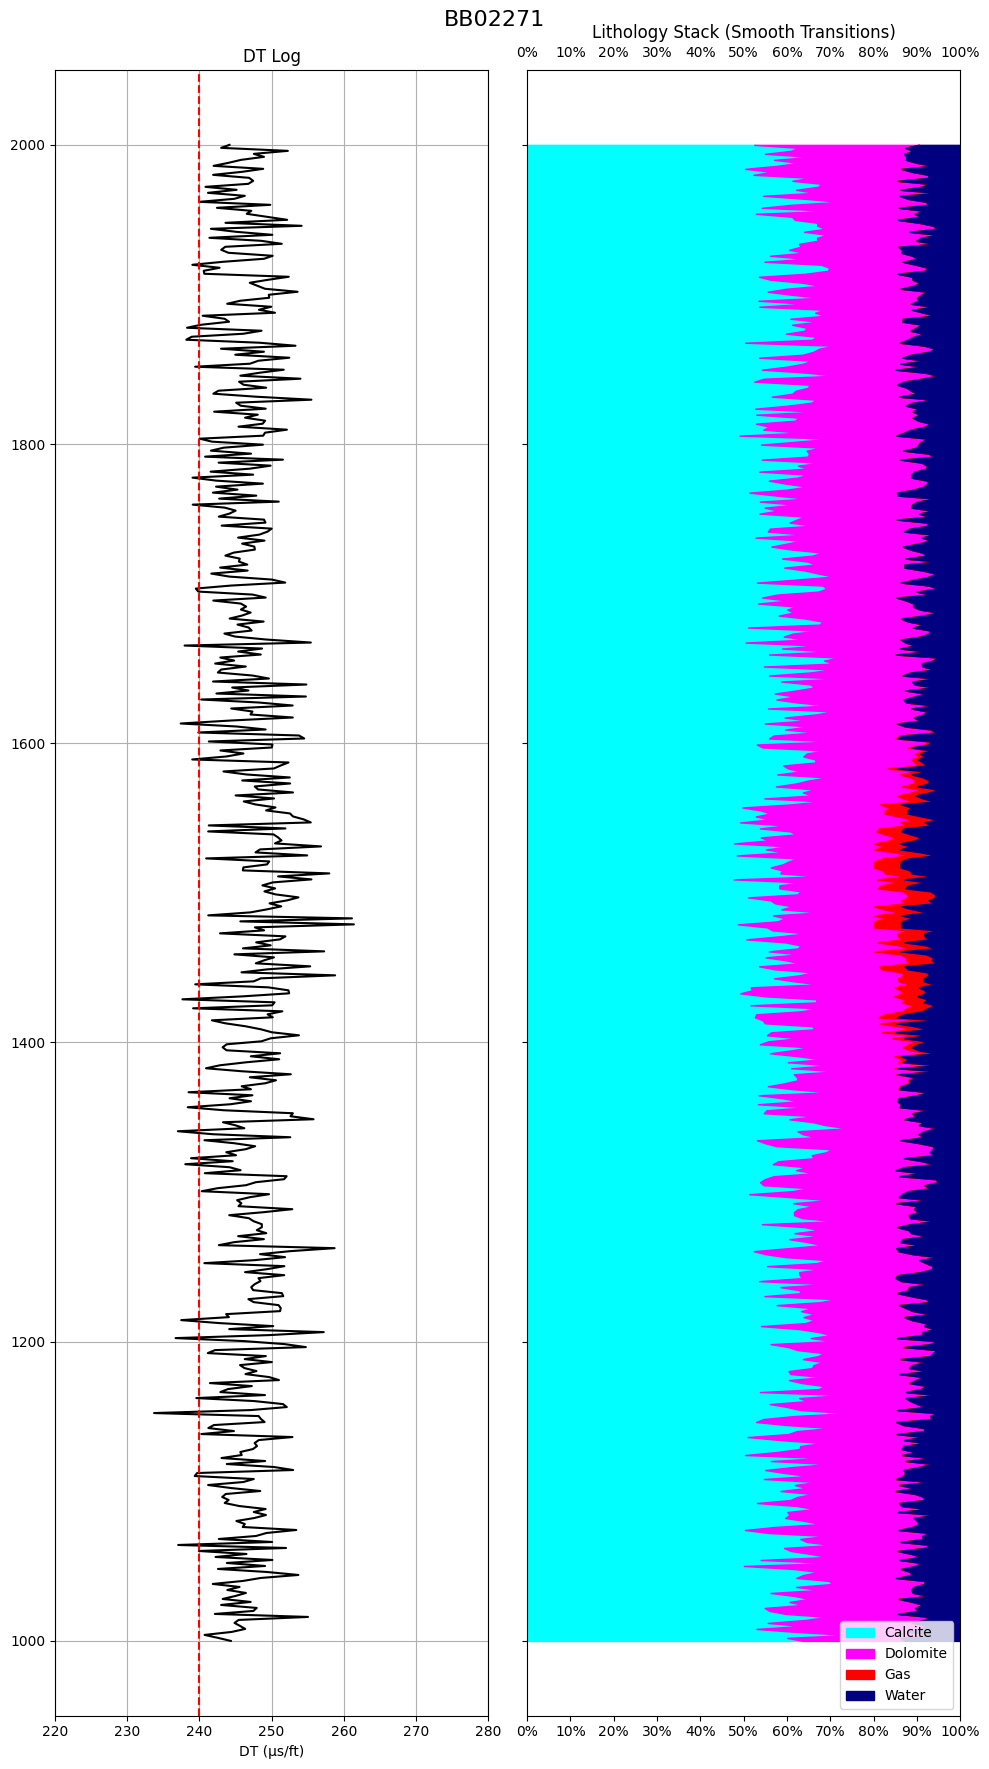

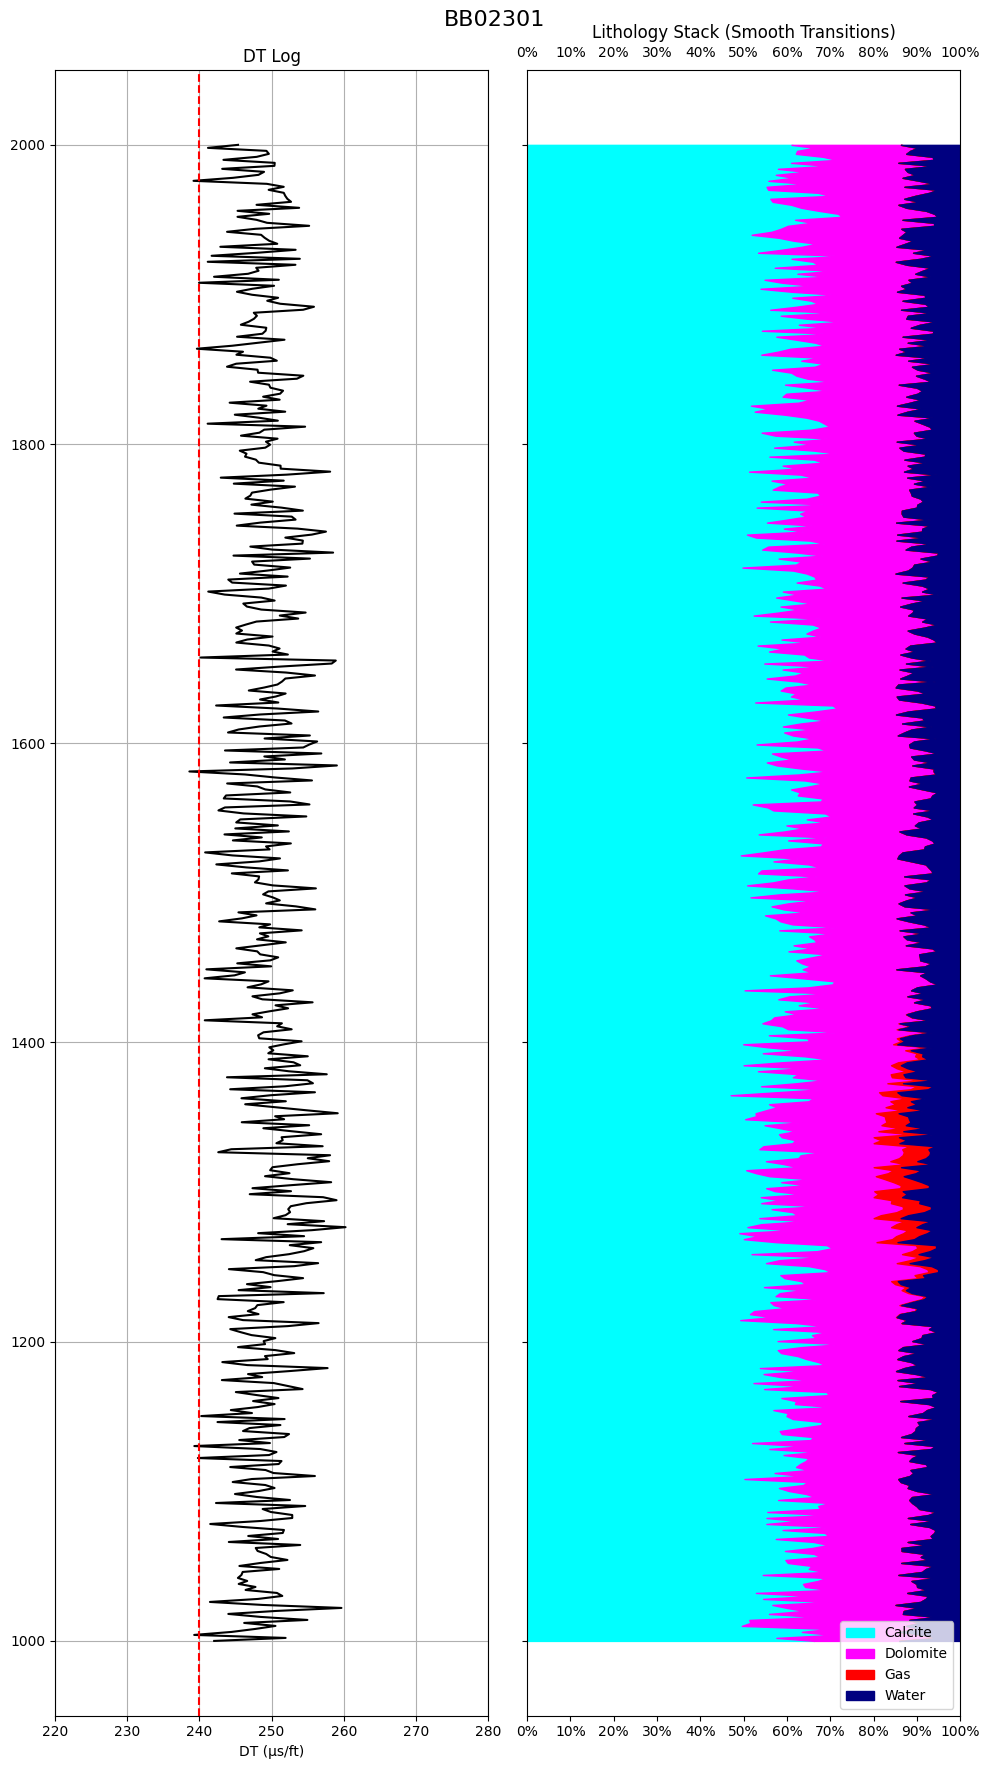

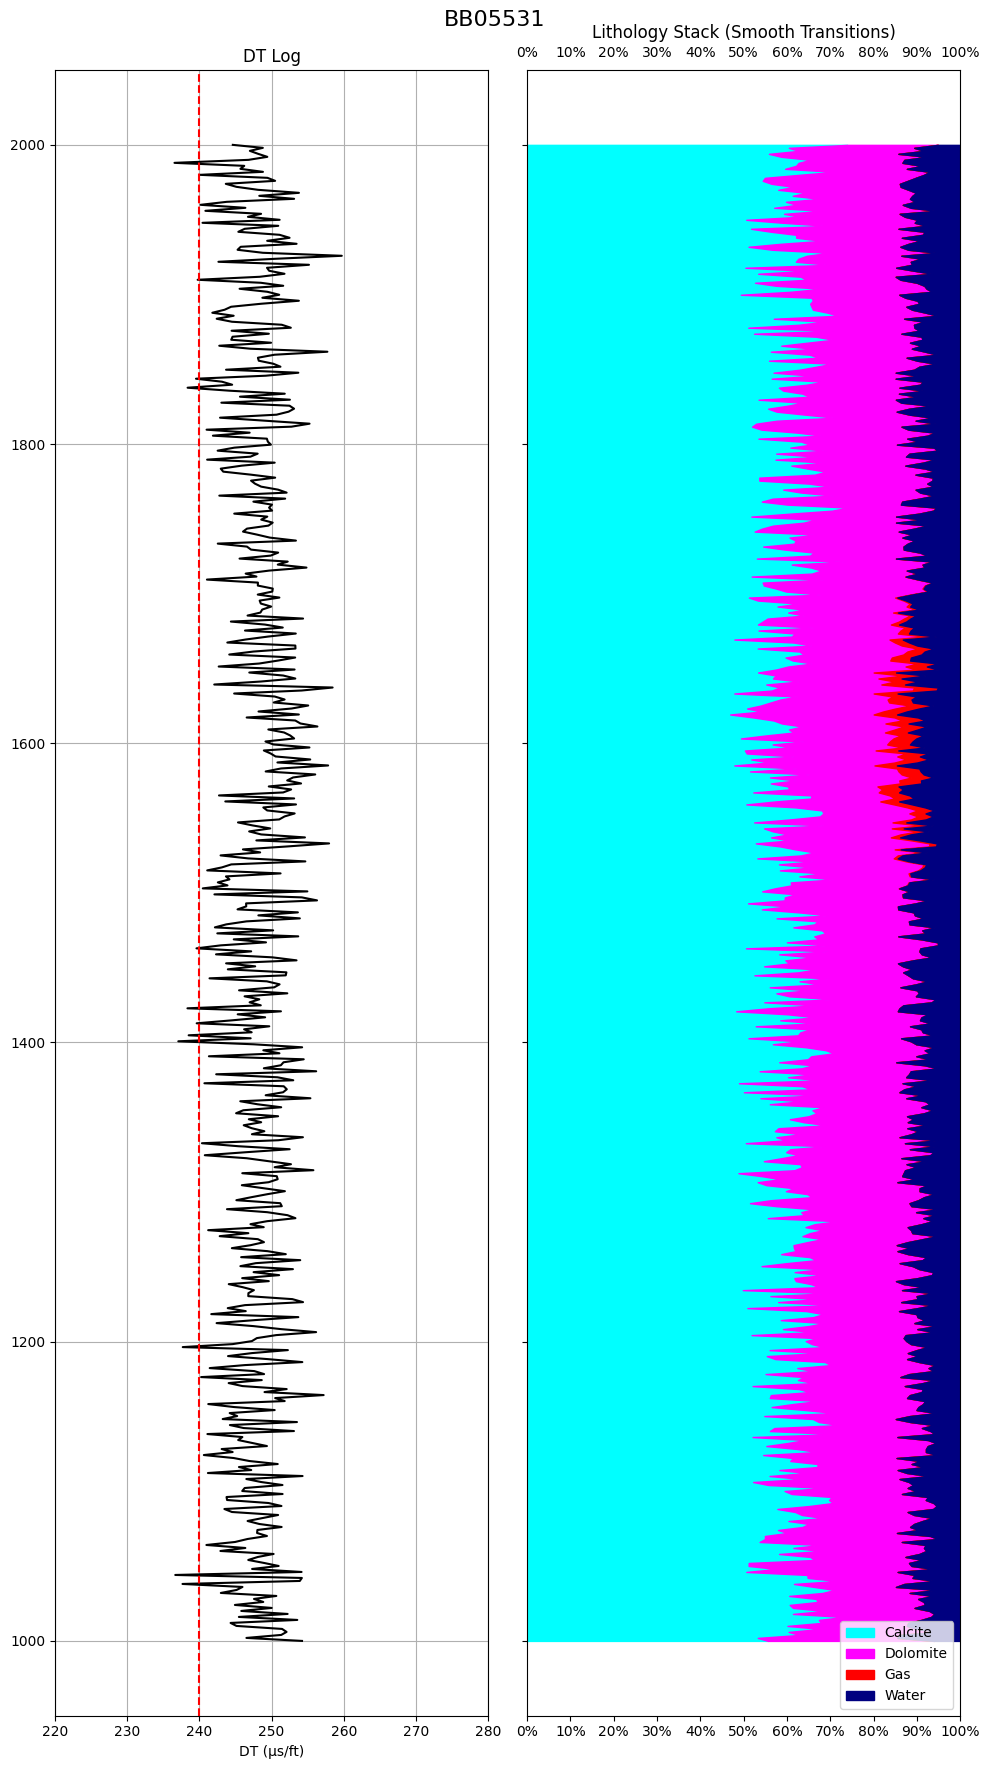

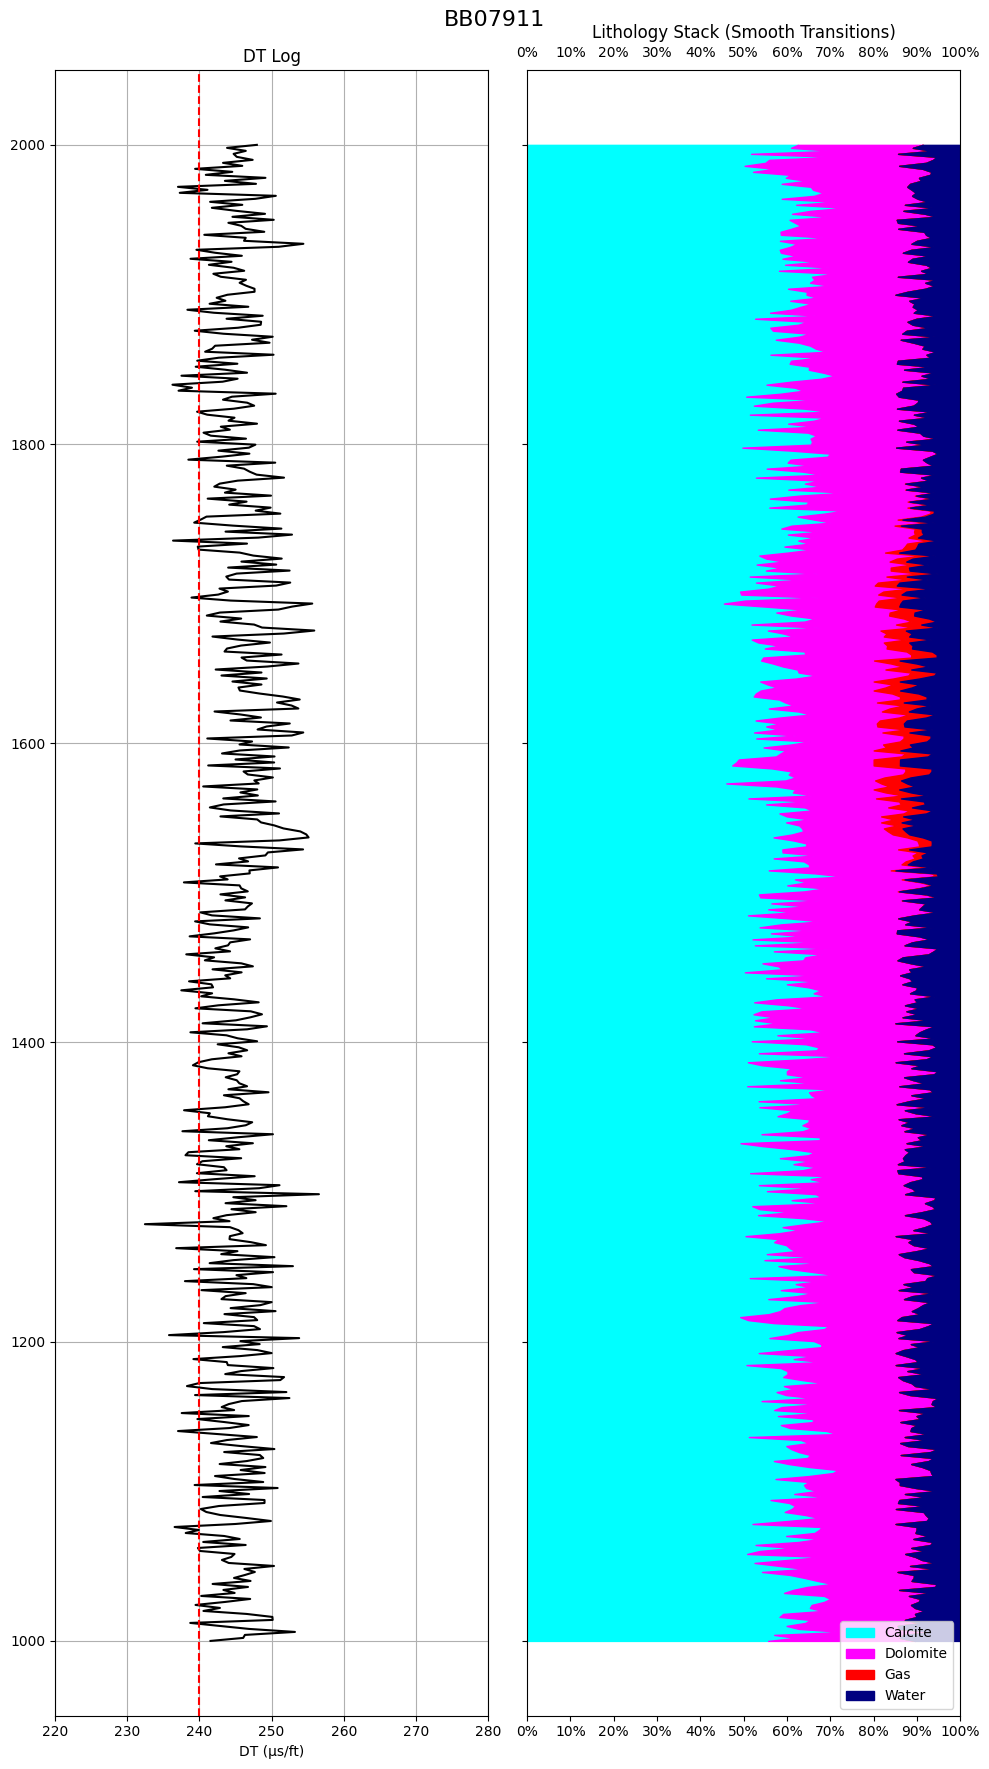

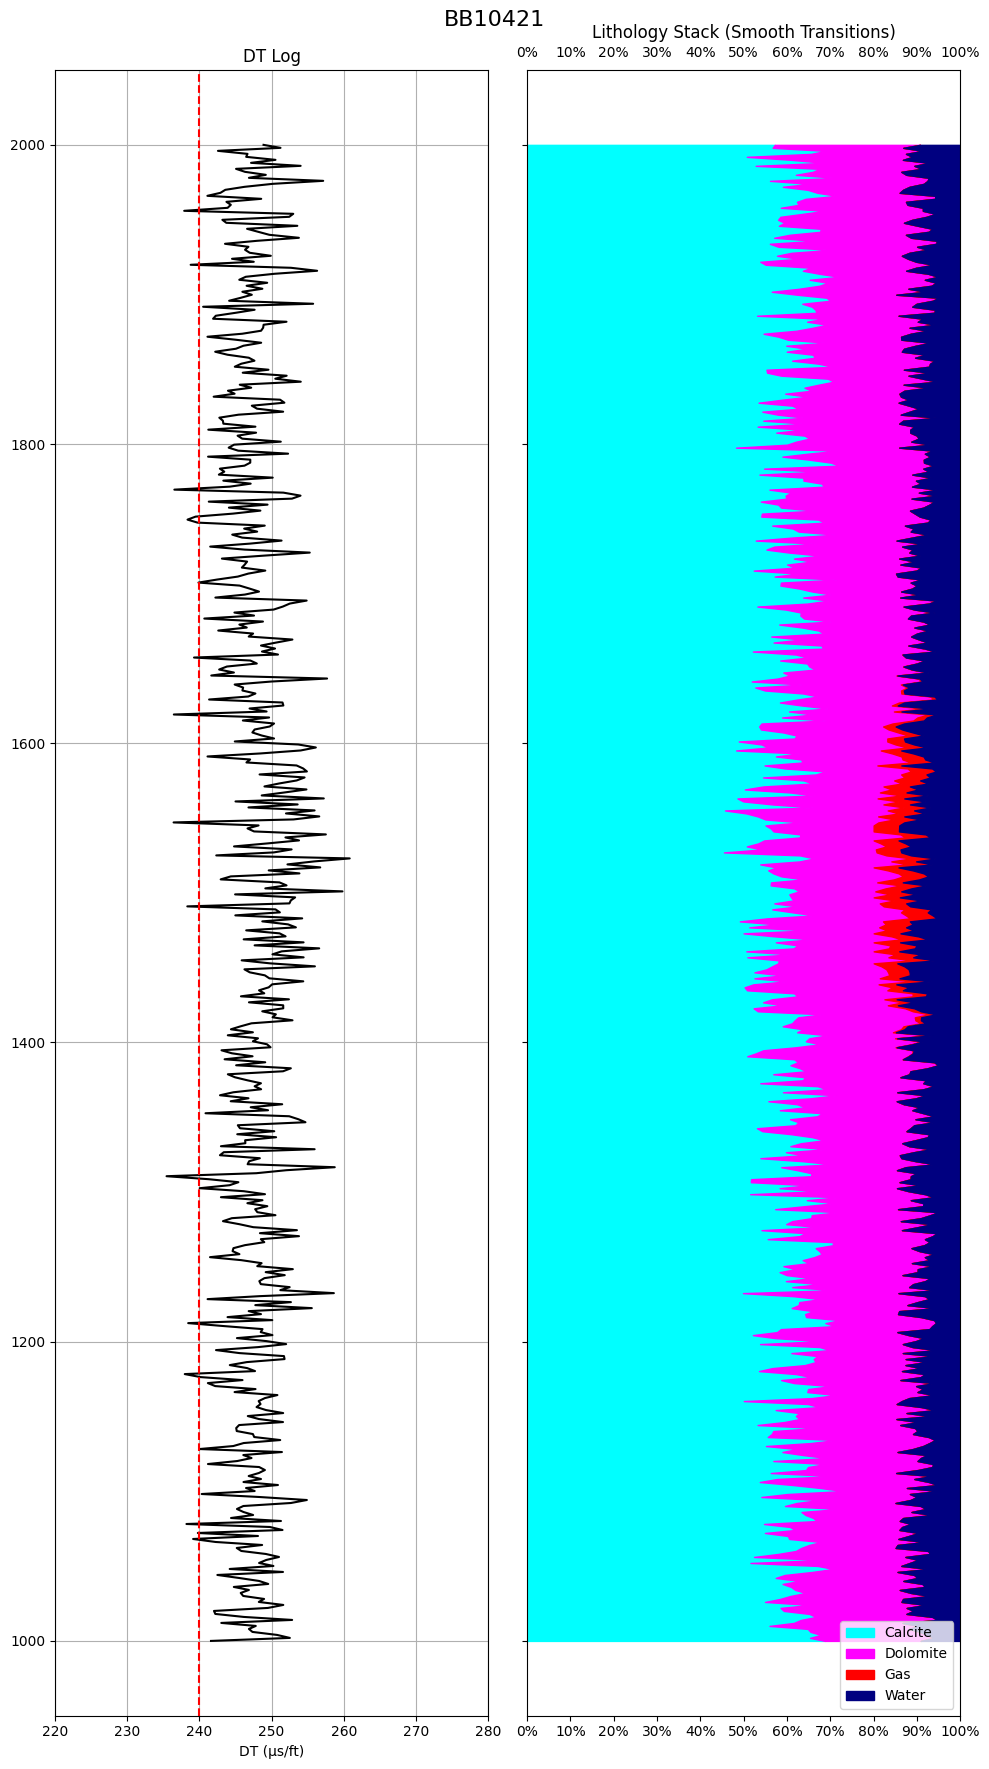

In [121]:
las_files = sorted(glob.glob("BAB_litho_clay_smooth_logs_3/*.las"))

for file in las_files:
    las = lasio.read(file)
    well = las.well.WELL.value
    depth = las["DEPT"]
    dt = las["DT"]
    dolomite = las["DOLOMITE"] / 100
    calcite = las["CALCITE"] / 100
    #clay = las["CLAY"] / 100
    gas = las["GAS"] / 100
    water = las["WATER"] / 100

    fig, axs = plt.subplots(1, 2, figsize=(10, 18), sharey=True)
    fig.suptitle(well, fontsize=16)

    axs[0].plot(dt, depth, color='black')
    axs[0].axvline(x=240, color='red', linestyle='--')
    axs[0].set_xlim(220, 280)
    axs[0].invert_yaxis()
    axs[0].set_xlabel("DT (µs/ft)")
    axs[0].set_title("DT Log")
    axs[0].grid(True)

    bottom = np.zeros_like(depth)
    axs[1].fill_betweenx(depth, bottom, bottom + calcite, color="#00FFFF", label="Calcite")
    bottom += calcite

    axs[1].fill_betweenx(depth, bottom, bottom + dolomite, color="#FF00FF", label="Dolomite")
    bottom += dolomite

    #axs[1].fill_betweenx(depth, bottom, bottom + clay, color="#A0522D", label="Clay")
    #bottom += clay
    axs[1].fill_betweenx(depth, bottom, bottom + gas, color="red", label="Gas")
    bottom += gas
    axs[1].fill_betweenx(depth, bottom, 1, color="navy", label="Water")

    axs[1].set_xlim(0, 1)
    axs[1].set_xticks(np.linspace(0, 1, 11))
    axs[1].set_xticklabels([f"{int(x*100)}%" for x in np.linspace(0, 1, 11)])
    axs[1].tick_params(axis='x', labeltop=True, labelbottom=True)
    axs[1].xaxis.set_label_position('top')
    axs[1].invert_yaxis()
    axs[1].set_title("Lithology Stack (Smooth Transitions)")
    axs[1].legend(loc="lower right")

    plt.tight_layout()
    plt.show()
